#### Loading bechmark structure

## Improvements for code speed
2024-12-20

In [1]:
import dataset_measure
import pathlib
import time
import pandas as pd
from rust_sasa_python import calculate_sasa_at_atom_level, calculate_sasa_at_residue_level
import biotite.structure.sasa as sasa
import biotite.structure as struc
import biotite.structure.info as struc_info
from Bio.PDB import ShrakeRupley
import numpy as np
import matplotlib.pyplot as plt
import time
import math

structure_basePath = pathlib.Path("../ressources/ISS AF_DMI_structures").absolute()
structure_folders = [structure_basePath / p for p in ['AF_DMI_structures1', 'AF_DMI_structures2', 'AF_DMI_structures3']]
solved_basePath = pathlib.Path("../ressources/ISS DMI_solved_structures").absolute()
solvedHydrogen_basePath = pathlib.Path("../ressources/ISS DMI_solved_structures hydrogens").absolute()

In [2]:
sampleStructure_name = "DOC_MAPK_RevD_3_3TEI"
sampleStructure_name = "LIG_NRP_CendR_1_2ORZ"
sampleStructure_path = structure_folders[1] / sampleStructure_name / "ranked_0.pdb"
sampleStructure = dataset_measure.OpenStructure(sampleStructure_path)
print(type(sampleStructure[0]), type(sampleStructure[1]))
print(sampleStructure[1])

<class 'Bio.PDB.Structure.Structure'> <class 'biotite.structure.AtomArrayStack'>
Model 1
    A       1  ASP N      N        -8.310   -4.385  -12.261
    A       1  ASP H      H        -7.533   -4.472  -12.900
    A       1  ASP H2     H        -8.967   -5.134  -12.425
    A       1  ASP H3     H        -8.752   -3.485  -12.380
    A       1  ASP CA     C        -7.744   -4.485  -10.903
    A       1  ASP HA     H        -7.281   -5.466  -10.801
    A       1  ASP C      C        -8.815   -4.338   -9.852
    A       1  ASP CB     C        -6.645   -3.443  -10.693
    A       1  ASP HB2    H        -6.171   -3.615   -9.727
    A       1  ASP HB3    H        -7.091   -2.448  -10.691
    A       1  ASP O      O        -9.608   -3.399   -9.922
    A       1  ASP CG     C        -5.602   -3.528  -11.800
    A       1  ASP OD1    O        -5.642   -4.552  -12.520
    A       1  ASP OD2    O        -4.958   -2.495  -12.026
    A       2  GLN N      N        -8.838   -5.263   -8.899
    A      

#### Benchmark

In [151]:
# Tests for chains
s0 = sampleStructure[0]
chains = [s for s in set(s0.get_chains())]
print(chains[0].id)
assert len(chains) == 2

chain1 = s0[0][chains[0].id]
chain2 = s0[0][chains[1].id]



A


In [10]:
struc.get_chains(sampleStructure[1][0])

array(['A', 'B'], dtype='<U4')

In [21]:
#Rewrite using Biotite
def calculate_buried_area(structure, chains, chain1, chain2):
    chains = struc.get_chains(structure)
    assert len(chains) == 2
    chain1 = structure[structure.chain_id == chains[0]]
    chain2 = structure[structure.chain_id == chains[1]]

    sasa12 = np.sum([s for s in sasa(structure, probe_radius=1.4) if math.isfinite(s)])
    sasa1 = np.sum([s for s in sasa(chain1, probe_radius=1.4) if math.isfinite(s)])
    sasa2 = np.sum([s for s in sasa(chain2, probe_radius=1.4) if math.isfinite(s)])
    print(sasa12, sasa1, sasa2)
    buried_area = (sasa1 + sasa2 - sasa12)
    return round(buried_area, 3)

In [22]:
def EvaluateStructure_Benchmark(path: pathlib.Path, structure_name: str = "") -> dict|None:
    """
        Measures the pdb file given by path
    """
    _startTime = time.time()

    file_name = path.name
    structure, structure_biotite = dataset_measure.OpenStructure(path, structure_name)
    _timea1 = time.time()
    if structure is None or structure_biotite is None: return None

    # If the structure contains only a single model, convert AtomArrayStack to AtomArray
    if structure_biotite.stack_depth() == 1:
        atom_array = structure_biotite[0]
    else:
        return "The provided structure contains multiple models. Please provide a structure with a single model."

    chains = struc.get_chains(structure_biotite)
    if len(chains) != 2:
        print("Wrong number of chains")
        return
    print(chains)
    chain1 = atom_array[atom_array.chain_id == chains[0]]
    chain2 = atom_array[atom_array.chain_id == chains[1]]

    buried_area = dataset_measure.calculate_buried_area(structure)
    _timeb1 = time.time()
    hbonds = dataset_measure.find_h_bonds(structure, structure_biotite)
    _timeb2 = time.time()
    min_distance = dataset_measure.minimum_interface_distance(structure)
    _timeb3 = time.time()
    salt_bridges = dataset_measure.find_salt_bridges(structure)
    _timeb4 = time.time()
    hydrophobic_interactions = dataset_measure.find_hydrophobic_interactions(structure)
    _timeb5 = time.time()
    buried_area2 = calculate_buried_area(structure, chains, chain1, chain2)
    _timeb6 = time.time()

    print(f"Opening Structure: {round((_timea1 - _startTime)*1000, 0)} ms")
    print(f"Buried surface Area: {round((_timeb1 - _timea1)*1000, 0)} ms")
    print(f"H Bonds: {round((_timeb2 - _timeb1)*1000, 0)} ms")
    print(f"Min. Interface Distance: {round((_timeb3 - _timeb2)*1000, 0)} ms")
    print(f"Salt bridges: {round((_timeb4 - _timeb3)*1000, 0)} ms")
    print(f"Hydrophobic interactions: {round((_timeb5 - _timeb4)*1000, 0)} ms")thud
    print(f"Buried surface Area (new): {round((_timeb6 - _timeb5)*1000, 0)} ms")
    print(f"Total: {round((_timeb6 - _startTime), 3)} s")

    return {
        'structure_name': structure_name,
        'file': file_name,
        'hbonds': hbonds,
        'salt_bridges': salt_bridges,
        'buried_area': buried_area,
        "buried_area2": buried_area2,
        'min_distance': min_distance,
        'hydrophobic_interactions': hydrophobic_interactions
    }

EvaluateStructure_Benchmark(sampleStructure_path, sampleStructure_name)

# AF DOC_MAPK_RevD_3_3TEI
# 
# Opening Structure: 55.0 ms
# Buried surface Area: 2097.0 ms
# H Bonds: 32.0 ms
# Min. Interface Distance: 5.0 ms
# Salt bridges: 4.0 ms
# Hydrophobic interactions: 81.0 ms
# Total: 2.423 s

['A' 'B']
OldSASA 7569.796706247292 7540.955918076798 796.1261116900383


AttributeError: 'Structure' object has no attribute 'chain_id'

#### Improving SASA calculations

In [5]:
from rust_sasa_python import calculate_sasa_at_atom_level
residue_sasa_values = calculate_sasa_at_atom_level(str(sampleStructure_path)) # Also supports mmCIF files!

In [ ]:
residue_sasa_values

In [3]:
import biotite.structure.sasa as sasa
import biotite.structure as struc

In [ ]:
atom_array = sampleStructure[1][0]
atom_array

In [11]:
chain1_atoms = atom_array[atom_array.chain_id == chains[0].id]
chain2_atoms = atom_array[atom_array.chain_id == chains[1].id]

In [12]:
sasa1 = sasa(chain1_atoms)
sasa2 = sasa(chain2_atoms)
sasa12 = sasa(atom_array)
d = {}
for i, s in enumerate(sasa12):
    d[i] = {
        "resname": atom_array[i].res_name, 
        "atom_name": atom_array[i].atom_name,  
        "sasa": s
    }
df = pd.DataFrame(d).transpose()

In [ ]:
sasa12

In [ ]:
df

In [ ]:
print(len(chain1_atoms), len(chain2_atoms), len(atom_array), len(chain1_atoms)+ len(chain2_atoms))

In [75]:
# With Biopandas

In [14]:
from Bio.PDB import ShrakeRupley
import numpy as np

In [ ]:
structure = sampleStructure[0]
chains = [c for c in structure.get_chains()]

# Calculate SASA for the whole structure
sasa = ShrakeRupley()
sasa.compute(structure, level="A")
total_area = np.sum(atom.sasa for atom in structure.get_atoms())

# Calculate buried area for each chain separately
chain1 = structure[0][chains[0].id]
chain2 = structure[0][chains[1].id]

sasa.compute(chain1, level="A")
area_ch1 = np.sum(atom.sasa for atom in chain1.get_atoms())

sasa.compute(chain2, level="A")
area_ch2 = np.sum(atom.sasa for atom in chain2.get_atoms())

# Calculate buried area
buried_area = (area_ch1 + area_ch2 - total_area)

In [16]:
sasa = ShrakeRupley()
sasa.compute(structure, level="A")

In [17]:
x = [{"resname": a.get_parent().resname, "atom_name": a.element, "sasa": a.sasa} for a in structure.get_atoms()]

In [ ]:
x

Oh boy..

In [ ]:
#Read out result of curie.utmb.edu in clipboard

In [111]:
d = []
for a in sampleStructure[1][0]:
    d.append({
        "Chain": a.chain_id,
        "Res_ID": a.res_id,
        "Residue": a.res_name,
        "Atom": a.atom_name,
        "Element": a.element
    })
df = pd.DataFrame(d)

t0 = time.time()
residue_sasa_values = calculate_sasa_at_atom_level(str(sampleStructure_path), n_points=100, probe_radius=1.4)
df["RustSASA"] = residue_sasa_values
t1 = time.time()

sasa12 = sasa(sampleStructure[1][0], ignore_ions=False, probe_radius=1.4, point_number=100)
df["Biotite SASA"] = sasa12
t2 = time.time()

sasaSR = ShrakeRupley(probe_radius=1.4, n_points=100)
sasaSR.compute(sampleStructure[0], level="A")
df["Biopandas SASA"] = [a.sasa for a in sampleStructure[0].get_atoms()]
t3 = time.time()

sasaOnline = [] # https://curie.utmb.edu/getarea.html; r=1.4A, no water gradient
with open(f"dev/onlineSASA/{sampleStructure_name}.txt", "r") as f:
    while (line := f.readline()):
        com = line.strip("\n").split(" ")
        if len(com) <= 2:
            continue
        sasaOnline.append(float(com[-1]))
df["Curie UTMB SASA"] = sasaOnline

dfH = df[df["Element"] == "H"]
dfHless = df[df["Element"] != "H"]

print(f"RustSASA: {round((t1 - t0)*1000, 0)} ms")
print(f"Biotite SASA: {round((t2 - t1)*1000, 0)} ms")
print(f"Biopandas SASA: {round((t3 - t2)*1000, 0)} ms")

df

RustSASA: 17.0 ms
Biotite SASA: 10.0 ms
Biopandas SASA: 395.0 ms


,Chain,Res_ID,Residue,Atom,Element,RustSASA,Biotite SASA,Biopandas SASA,Curie UTMB SASA
0,A,1,ASP,N,N,5.883323,44.130680,1.093588,35.13
1,A,1,ASP,H,H,8.494866,NaN,10.193840,0.00
2,A,1,ASP,H2,H,19.538193,NaN,20.387680,0.00
3,A,1,ASP,H3,H,14.441272,NaN,16.140246,0.00
4,A,1,ASP,CA,C,0.000000,1.351941,0.000000,2.67
...,...,...,...,...,...,...,...,...,...
2235,B,4,ARG,NH2,N,0.000000,0.000000,0.000000,0.16
2236,B,4,ARG,HH21,H,0.000000,NaN,0.000000,0.00
2237,B,4,ARG,HH22,H,0.000000,NaN,0.000000,0.00
2238,B,4,ARG,CZ,C,0.000000,0.000000,0.000000,0.02


In [30]:
dfH

,Chain,Residue,Atom,Element,RustSASA,Biotite SASA,Biopandas SASA,Curie UTMB SASA
1,A,ASP,H,H,8.494866,NaN,10.193840,0.0
2,A,ASP,H2,H,19.538193,NaN,20.387680,0.0
3,A,ASP,H3,H,14.441272,NaN,16.140246,0.0
5,A,ASP,HA,H,0.000000,NaN,0.000000,0.0
8,A,ASP,HB2,H,0.000000,NaN,0.000000,0.0
...,...,...,...,...,...,...,...,...
2231,B,ARG,HE,H,0.000000,NaN,0.849487,0.0
2233,B,ARG,HH11,H,0.000000,NaN,0.000000,0.0
2234,B,ARG,HH12,H,0.000000,NaN,0.000000,0.0
2236,B,ARG,HH21,H,0.000000,NaN,0.000000,0.0


In [31]:
dfHless

,Chain,Residue,Atom,Element,RustSASA,Biotite SASA,Biopandas SASA,Curie UTMB SASA
0,A,ASP,N,N,5.883323,44.130680,1.093588,-11.08
4,A,ASP,CA,C,0.000000,1.351941,0.000000,3.26
6,A,ASP,C,C,0.000000,0.000000,0.000000,0.00
7,A,ASP,CB,C,0.000000,2.703881,0.000000,0.38
10,A,ASP,O,O,12.681982,15.989249,13.928967,-0.42
...,...,...,...,...,...,...,...,...
2230,B,ARG,NE,N,1.176665,1.161334,0.000000,-3.67
2232,B,ARG,NH1,N,0.000000,0.000000,0.000000,0.00
2235,B,ARG,NH2,N,0.000000,0.000000,0.000000,-1.72
2238,B,ARG,CZ,C,0.000000,0.000000,0.000000,-0.52


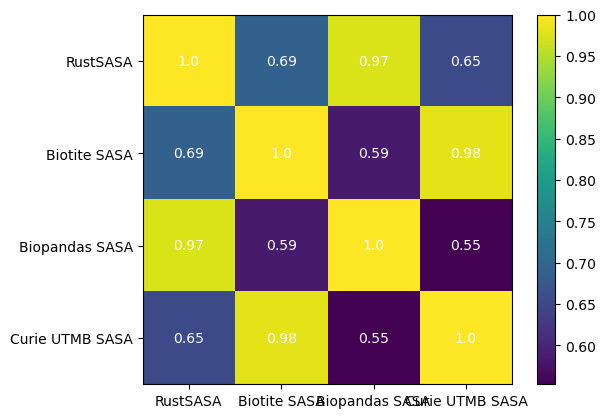

In [121]:
#Plotting
columns = ["RustSASA", "Biotite SASA", "Biopandas SASA", "Curie UTMB SASA"]
corr_input = []
for i in range(len(columns)):
    corr_input.append(np.array(dfHless[columns[i]]))
corr_input = np.array(corr_input)
correlations = np.corrcoef(corr_input)

ims = plt.imshow(correlations)
plt.colorbar(ims)
plt.xticks(range(len(columns)), labels=columns)
plt.yticks(range(len(columns)), labels=columns)
for i in range(len(columns)):
    for j in range(len(columns)):
        text = plt.text(j, i, round(correlations[i, j],2), ha="center", va="center", color="w")
plt.show()

C:\Users\abril\AppData\Local\Temp\ipykernel_18504\747825835.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


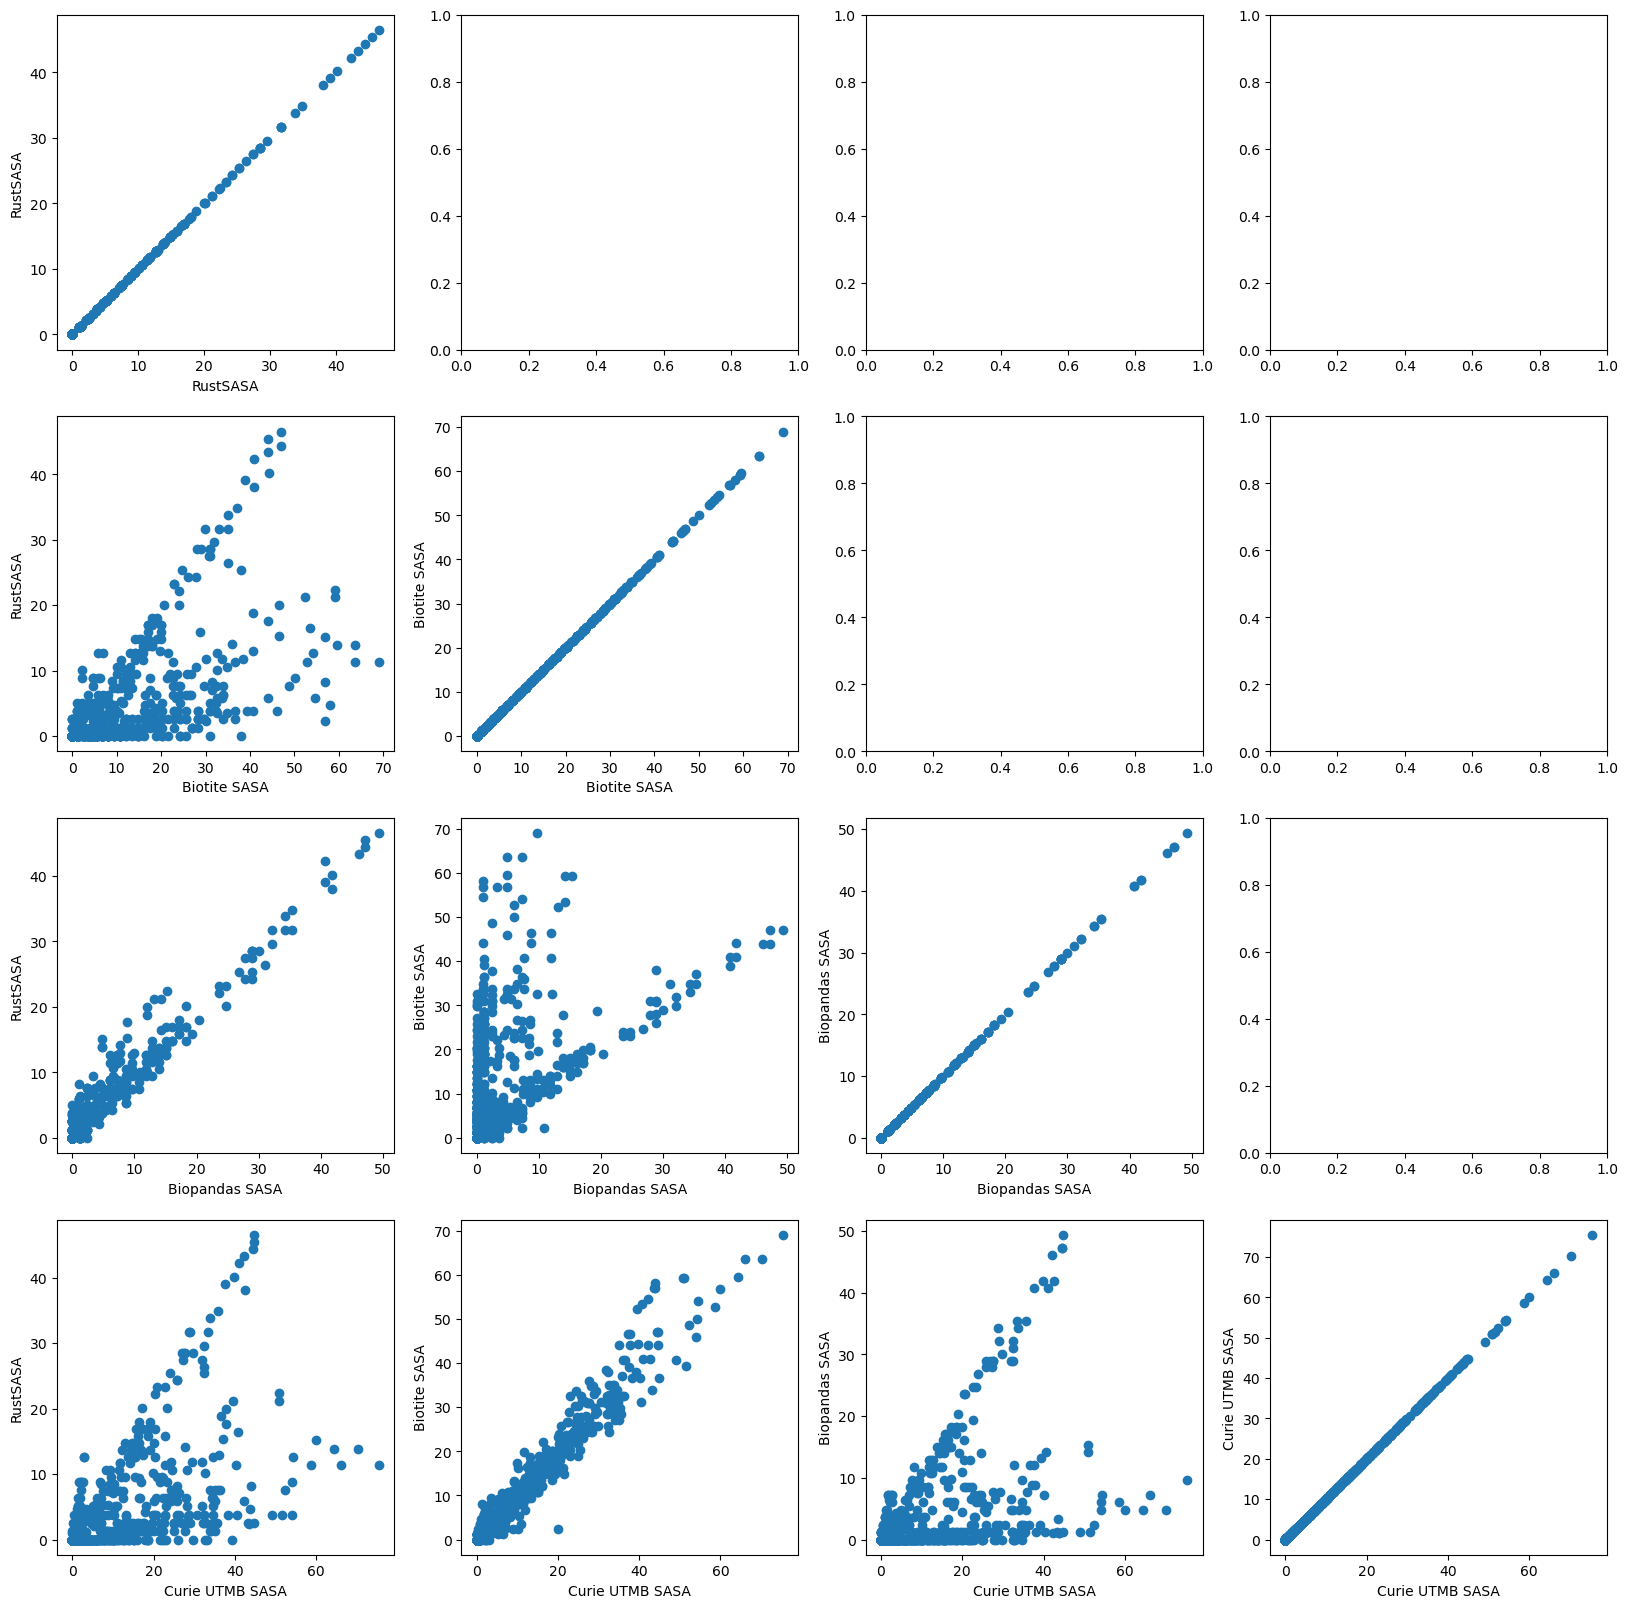

In [52]:
fig, axes = plt.subplots(len(columns),len(columns))
fig.set_size_inches(5*len(columns), 5*len(columns))

columns = ["RustSASA", "Biotite SASA", "Biopandas SASA", "Curie UTMB SASA"]
i1 = 0
for i1, c1 in enumerate(columns):
    for i2, c2 in enumerate(columns):
        if i2 > i1:
            continue
        axes[i1, i2].set_xlabel(c1)
        axes[i1, i2].set_ylabel(c2)
        axes[i1, i2].scatter(dfHless[c1], dfHless[c2])
fig.show()

Calculating at residue level

In [88]:
def SASA_Benchmark_ResidueLevel(onlineSASA_file_suffix:str):

    d = []
    for i, r in zip(*struc.get_residues(sampleStructure[1][0])):
        d.append({
            "Nr": i,
            "Residue": r
        })
    df = pd.DataFrame(d)

    t0 = time.time()
    residue_sasa_values = calculate_sasa_at_residue_level(str(sampleStructure_path), n_points=100, probe_radius=1.4)
    df["RustSASA"] = residue_sasa_values
    t1 = time.time()

    _biotiteR = {r.res_id:0 for r in sampleStructure[0].get_residues()}
    for i, s in enumerate(sasa(sampleStructure[1][0], ignore_ions=False, probe_radius=1.4, point_number=100)):
        r_id = sampleStructure[1][0][i].res_id
        if not (math.isnan(s)):
            _biotiteR[r_id] += s
    df["Biotite SASA"] = list(_biotiteR.values())
    t2 = time.time()

    sasaSR = ShrakeRupley(probe_radius=1.4, n_points=100)
    sasaSR.compute(sampleStructure[0], level="A")
    _biopandasR = {r.res_id:0 for r in sampleStructure[0].get_residues()}
    for i, s in enumerate([a.sasa for a in sampleStructure[0].get_atoms()]):
        r_id = sampleStructure[1][0][i].res_id
        if not (math.isnan(s)):
            _biopandasR[r_id] += s
    df["Biopandas SASA"] = list(_biopandasR.values())
    t3 = time.time()

    sasaOnline = [] # https://curie.utmb.edu/getarea.html; r=1.4A, no water gradient
    with open(f"dev/onlineSASA/{sampleStructure_name}_{onlineSASA_file_suffix}.txt", "r") as f:
        while (line := f.readline()):
            com = line.strip("\n").split(" ")
            if len(com) <= 2:
                continue
            sasaOnline.append(float(com[-1]))
    df["Curie UTMB SASA"] = sasaOnline

    dfHless = df[df["Element"] != "H"]

    print(f"RustSASA: {round((t1 - t0)*1000, 0)} ms")
    print(f"Biotite SASA: {round((t2 - t1)*1000, 0)} ms")
    print(f"Biopandas SASA: {round((t3 - t2)*1000, 0)} ms")

    return df
SASA_Benchmark_ResidueLevel("residues")

AttributeError: 'Residue' object has no attribute 'res_id'

In [100]:
struc.get_residues(sampleStructure[1][0])[0]

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135,   1,   2,   3,   4])

In [73]:
sasaSR = ShrakeRupley(probe_radius=1.4, n_points=100)
sasaSR.compute(sampleStructure[0], level="A")

In [77]:
sasas = [a.sasa for a in sampleStructure[0].get_atoms()]

In [74]:
[a.sasa for a in sampleStructure[0].get()]

[1.0935884027146072,
 10.193839842368158,
 20.387679684736316,
 16.140246417082917,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 13.928967312815365,
 1.2076282160399163,
 11.786049264689925,
 28.929393649693452,
 0.0,
 0.0,
 0.0,
 3.3979466141227195,
 0.0,
 0.0,
 0.0,
 7.645379881776119,
 1.0714590240627204,
 0.0,
 11.892813149429518,
 13.591786456490878,
 7.245769296239498,
 15.310237638004502,
 25.484599605920398,
 27.183572912981756,
 30.00085267375617,
 0.0,
 11.043326495898839,
 0.0,
 0.0,
 0.0,
 0.0,
 1.6989733070613597,
 8.571672192501763,
 0.0,
 0.8494866535306799,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8494866535306799,
 4.247433267653399,
 0.0,
 0.0,
 0.0,
 1.6989733070613597,
 0.0,
 0.0,
 8.494866535306798,
 0.0,
 6.038141080199582,
 21.237166338266995,
 14.441273110021557,
 4.247433267653399,
 0.0,
 7.645379881776119,
 0.0,
 5.946406574714759,
 0.0,
 0.0,
 0.0,
 0.0,
 1.6989733070613597,
 0.0,
 0.0,
 20.357721457191687,
 0.0,
 0.0,
 0.0,
 5.096919921184079,
 0.0,
 0.0,
 11.89

In [71]:
_biotiteR = {}
for i, s in enumerate(sasa(sampleStructure[1][0], ignore_ions=False, probe_radius=1.4, point_number=100)):
    r_id = sampleStructure[1][0][i].res_id - 1
    if r_id not in _biotiteR.keys():
        _biotiteR[r_id] = 0
    if not (math.isnan(s)):
        _biotiteR[r_id] += s
print(_biotiteR)

{0: 247.45433223247528, 1: 228.20005863904953, 2: 102.32414305210114, 3: 85.06885647773743, 4: 23.823174118995667, 5: 47.20245599746704, 6: 38.99285960197449, 7: 80.542720079422, 8: 76.74540567398071, 9: 31.09463119506836, 10: 112.88568043708801, 11: 65.203684091568, 12: 8.503311038017273, 13: 10.16740083694458, 14: 28.390751838684082, 15: 131.8118543624878, 16: 41.005088090896606, 17: 0.0, 18: 115.78588092327118, 19: 30.66998839378357, 20: 94.11290895938873, 21: 73.2025311589241, 22: 117.5033597946167, 23: 66.55798733234406, 24: 5.320652008056641, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 12.167465209960938, 30: 113.0823929309845, 31: 54.293911933898926, 32: 26.826138973236084, 33: 144.86995387077332, 34: 189.7029378414154, 35: 14.297539472579956, 36: 55.06482744216919, 37: 0.0, 38: 17.420005798339844, 39: 8.111642837524414, 40: 22.55549395084381, 41: 29.91977608203888, 42: 41.08791160583496, 43: 112.21106231212616, 44: 100.69317698478699, 45: 128.98226594924927, 46: 118.5573136806488, 

In [61]:
sampleStructure[1][0][0].res_id

1

In [ ]:

sasa(sampleStructure[1][0], ignore_ions=False, probe_radius=1.4, point_number=100) 

array([
	Atom(np.array([ -8.31 ,  -4.385, -12.261], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="ASP", hetero=False, atom_name="N", element="N"),
	Atom(np.array([ -7.533,  -4.472, -12.9  ], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="ASP", hetero=False, atom_name="H", element="H"),
	Atom(np.array([ -8.967,  -5.134, -12.425], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="ASP", hetero=False, atom_name="H2", element="H"),
	Atom(np.array([ -8.752,  -3.485, -12.38 ], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="ASP", hetero=False, atom_name="H3", element="H"),
	Atom(np.array([ -7.744,  -4.485, -10.903], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="ASP", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([ -7.281,  -5.466, -10.801], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="ASP", hetero=False, atom_name="HA", element="H"),
	Atom(np.array([-8.815, -4.338, -9.852], dtype=float

In [50]:
struc.get_residues(sampleStructure[1][0])[1][0]

'ASP'

In [49]:
for r in struc.get_residues(sampleStructure[1][0])[1]:
    print(r.chain_id)

AttributeError: 'numpy.str_' object has no attribute 'chain_id'

AttributeError: 'AtomArray' object has no attribute 'get_residues'

In [107]:
sampleStructure[1][0]

array([
	Atom(np.array([ -8.31 ,  -4.385, -12.261], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="ASP", hetero=False, atom_name="N", element="N"),
	Atom(np.array([ -7.533,  -4.472, -12.9  ], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="ASP", hetero=False, atom_name="H", element="H"),
	Atom(np.array([ -8.967,  -5.134, -12.425], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="ASP", hetero=False, atom_name="H2", element="H"),
	Atom(np.array([ -8.752,  -3.485, -12.38 ], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="ASP", hetero=False, atom_name="H3", element="H"),
	Atom(np.array([ -7.744,  -4.485, -10.903], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="ASP", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([ -7.281,  -5.466, -10.801], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="ASP", hetero=False, atom_name="HA", element="H"),
	Atom(np.array([-8.815, -4.338, -9.852], dtype=float

In [110]:
for a in sampleStructure[1][0]:
    print(a.res_id)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
25


In [125]:
_dfRes = {} 
for index, row in df.iterrows():
    name = f"{row['Chain']}-{row['Res_ID']}"
    if name not in _dfRes.keys():
        _dfRes[name] = {
            "Chain":row["Chain"], 
            "Residue":row["Residue"], 
            "ID":row["Res_ID"], 
            "RustSASA":0, 
            "Biotite SASA":0, 
            "Biopandas SASA":0}
    _dfRes[name]["RustSASA"] += float(row["RustSASA"])
    _dfRes[name]["Biotite SASA"] += float(row["Biotite SASA"]) if not math.isnan(row["Biotite SASA"]) else 0
    _dfRes[name]["Biopandas SASA"] += float(row["Biopandas SASA"])
dfRes = pd.DataFrame(_dfRes)
dfRes = dfRes.transpose()
dfRes

,Chain,Residue,ID,RustSASA,Biotite SASA,Biopandas SASA
A-1,A,ASP,1,104.987593,109.14191,103.667393
A-2,A,GLN,2,143.600894,129.33925,142.824417
A-3,A,ILE,3,27.764002,26.80608,27.260379
A-4,A,THR,4,69.153025,62.569021,63.803234
A-5,A,ALA,5,23.912549,23.823174,28.003101
...,...,...,...,...,...,...
A-135,A,GLY,135,83.567491,88.191133,90.254313
B-1,B,THR,1,143.420763,138.312422,148.448258
B-2,B,LYS,2,104.367157,98.860809,98.60395
B-3,B,PRO,3,84.834183,75.518063,84.324117


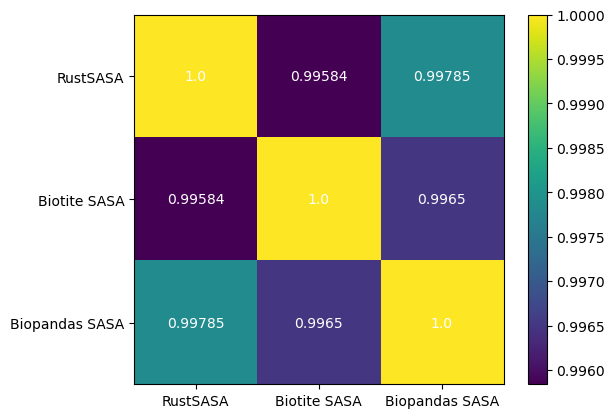

In [131]:
#Plotting
columns = ["RustSASA", "Biotite SASA", "Biopandas SASA"]
corr_input = []
for i in range(len(columns)):
    corr_input.append(np.array(dfRes[columns[i]]))
corr_input = np.array(corr_input).astype("float")
correlations = np.corrcoef(corr_input)

ims = plt.imshow(correlations)
plt.colorbar(ims)
plt.xticks(range(len(columns)), labels=columns)
plt.yticks(range(len(columns)), labels=columns)
for i in range(len(columns)):
    for j in range(len(columns)):
        text = plt.text(j, i, round(correlations[i, j],5), ha="center", va="center", color="w")
plt.show()

C:\Users\abril\AppData\Local\Temp\ipykernel_18504\858043799.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


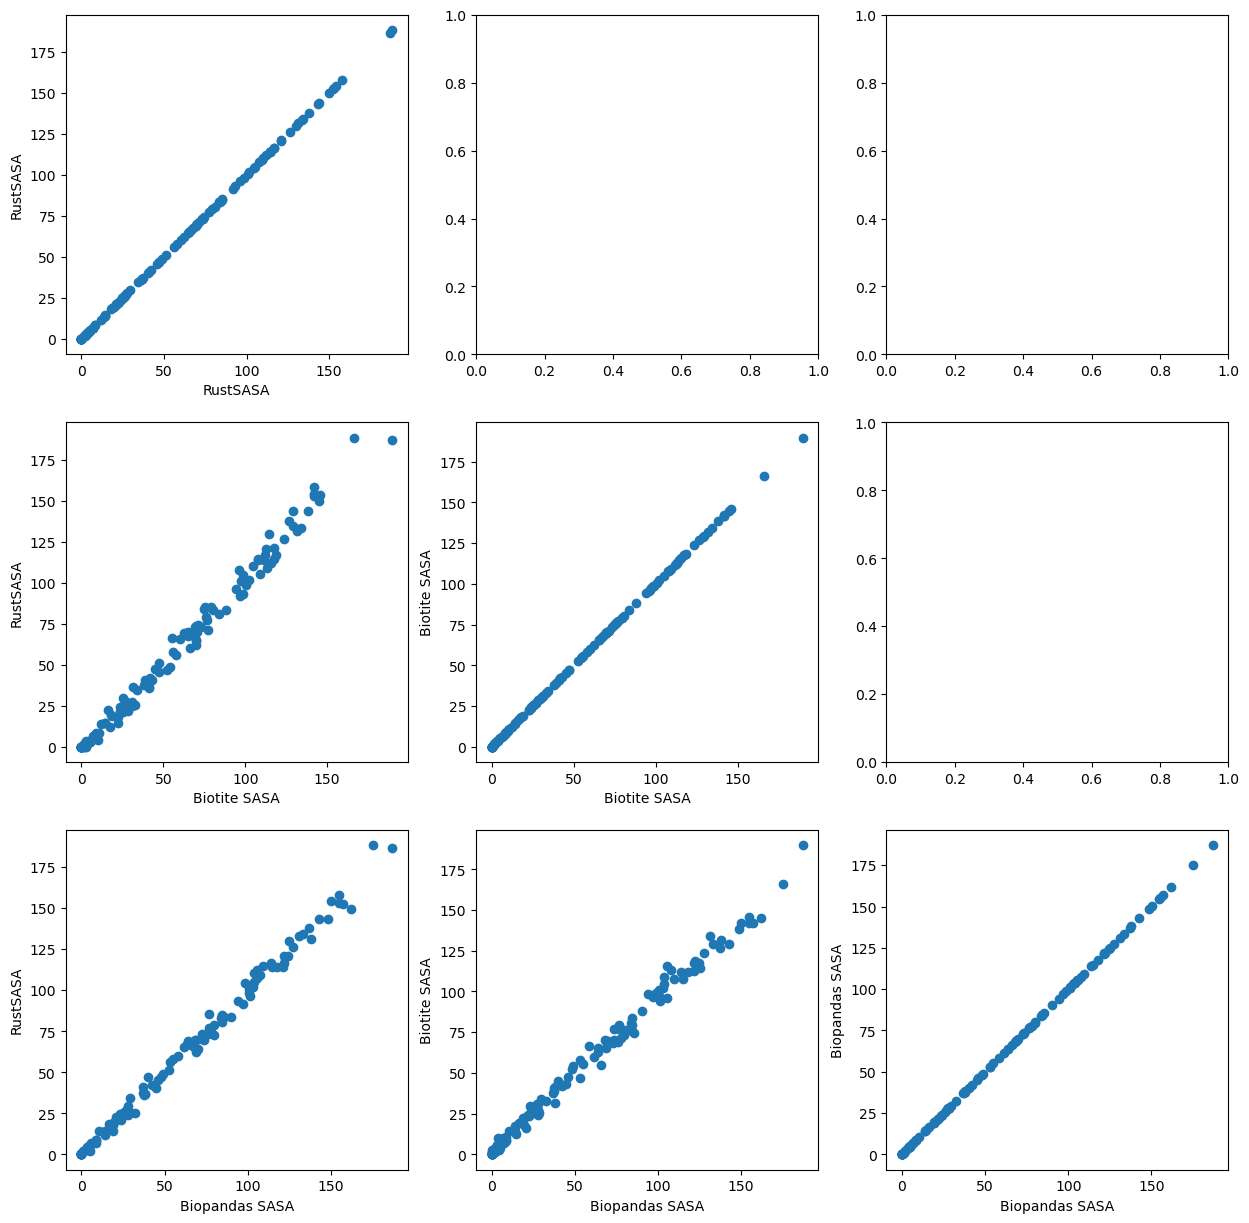

In [132]:
fig, axes = plt.subplots(len(columns),len(columns))
fig.set_size_inches(5*len(columns), 5*len(columns))

columns = ["RustSASA", "Biotite SASA", "Biopandas SASA"]
i1 = 0
for i1, c1 in enumerate(columns):
    for i2, c2 in enumerate(columns):
        if i2 > i1:
            continue
        axes[i1, i2].set_xlabel(c1)
        axes[i1, i2].set_ylabel(c2)
        axes[i1, i2].scatter(dfRes[c1], dfRes[c2])
fig.show()

In [154]:
print(np.sum(dfRes["Biotite SASA"]), np.sum(dfRes["Biopandas SASA"]))

7424.167113006115 7569.7967062472635


In [139]:
chain1 = sampleStructure[1][0][sampleStructure[1][0].chain_id == struc.get_chains(sampleStructure[1][0])[0]]
chain2 = sampleStructure[1][0][sampleStructure[1][0].chain_id == struc.get_chains(sampleStructure[1][0])[1]]
chain2

array([
	Atom(np.array([-4.932,  9.768, 16.704], dtype=float32), chain_id="B", res_id=1, ins_code="", res_name="THR", hetero=False, atom_name="N", element="N"),
	Atom(np.array([-4.142,  9.521, 17.283], dtype=float32), chain_id="B", res_id=1, ins_code="", res_name="THR", hetero=False, atom_name="H", element="H"),
	Atom(np.array([-4.727,  9.535, 15.743], dtype=float32), chain_id="B", res_id=1, ins_code="", res_name="THR", hetero=False, atom_name="H2", element="H"),
	Atom(np.array([-5.096, 10.762, 16.772], dtype=float32), chain_id="B", res_id=1, ins_code="", res_name="THR", hetero=False, atom_name="H3", element="H"),
	Atom(np.array([-6.152,  9.051, 17.152], dtype=float32), chain_id="B", res_id=1, ins_code="", res_name="THR", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-5.962,  7.978, 17.125], dtype=float32), chain_id="B", res_id=1, ins_code="", res_name="THR", hetero=False, atom_name="HA", element="H"),
	Atom(np.array([-7.268,  9.331, 16.156], dtype=float32), chain_id="B",